# Обучение с учителем: качество модели
Я стажёр в отделе цифровых технологий интернет-магазина «В один клик». Недавний отчёт показал снижение активности постоянных клиентов, поэтому наша цель — удержание клиентов через персонализированные предложения.

Решение:
Задача — создать модель, которая предскажет вероятность снижения покупательской активности в следующие три месяца. Для этого собраны данные по четырём группам признаков: коммуникация с клиентом, продуктовое и покупательское поведение, а также поведение на сайте. Модель будет использоваться для сегментации клиентов и разработки персонализированных предложений, чтобы повысить их активность.

In [1]:
!pip install phik
!pip install shap
!pip install matplotlib==3.5.0 -q
!pip install --upgrade shap 
!pip install -Uq scikit-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import shap
from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score, make_scorer, accuracy_score, roc_auc_score

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import SelectKBest, f_classif

from phik import phik_matrix

## Загрузка данных

In [3]:
market_file_df = pd.read_csv('/datasets/market_file.csv')
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', sep=';')

display(market_file_df.head())

display(market_money_df.head())

display(market_time_df.head())

display(money_df.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


Данные в файлах соответствуют описанию.

##  Предобработка данных

In [4]:
# Проверим информацию о каждом DataFrame (пропущенные значения, типы данных)
def check_data(df, name):
    print(f"Информация о {name}:")
    df.info()
    print(f"Пропущенные значения в {name}:")
    display(df.isnull().sum())
    print(f"Дубликаты в {name}: {df.duplicated().sum()}")

In [5]:
# Проверка market_file.csv
check_data(market_file_df, "market_file.csv")

Информация о market_file.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Дубликаты в market_file.csv: 0


In [6]:
# Проверка market_money.csv
check_data(market_money_df, "market_money.csv")

Информация о market_money.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
Пропущенные значения в market_money.csv:


id         0
Период     0
Выручка    0
dtype: int64

Дубликаты в market_money.csv: 0


In [7]:
# Проверка market_time.csv
check_data(market_time_df, "market_time.csv")

Информация о market_time.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
Пропущенные значения в market_time.csv:


id        0
Период    0
минут     0
dtype: int64

Дубликаты в market_time.csv: 0


In [8]:
# Проверка money.csv
check_data(money_df, "money.csv")

Информация о money.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB
Пропущенные значения в money.csv:


id         0
Прибыль    0
dtype: int64

Дубликаты в money.csv: 0


Вывод:

- в таблице money_df неправильный тип данных у столбца прибыль. Должен быть float.
- для удобной работы переименуем названия всех столбцов и значения в нижний регистр.
- для всех столбцов типа object выведем уникальные значения, так как в некоторых столбцах я обнаружил неявные дубликаты.

In [9]:
money_df['Прибыль'] = pd.to_numeric(money_df['Прибыль'].str.replace(',', '.'), errors='coerce')

money_df.dtypes

id           int64
Прибыль    float64
dtype: object

In [10]:
# Преобразование названий столбцов в нижний регистр
market_file_df.columns = market_file_df.columns.str.lower()
market_money_df.columns = market_money_df.columns.str.lower()
market_time_df.columns = market_time_df.columns.str.lower()
money_df.columns = money_df.columns.str.lower()

# Преобразование значений строк в нижний регистр
def convert_to_lowercase(df):
    for col in df.select_dtypes(include='object').columns:
        df[col] = df[col].str.lower()

convert_to_lowercase(market_file_df)
convert_to_lowercase(market_money_df)
convert_to_lowercase(market_time_df)
convert_to_lowercase(money_df)

In [11]:
def display_unique_values(df, df_name):
    print(f"Уникальные значения в таблице {df_name}:")
    for col in df.select_dtypes(include='object').columns:
        unique_values = df[col].unique()
        print(f"Столбец '{col}': {unique_values}")

In [12]:
display_unique_values(market_file_df, "market_file_df")

Уникальные значения в таблице market_file_df:
Столбец 'покупательская активность': ['снизилась' 'прежний уровень']
Столбец 'тип сервиса': ['премиум' 'стандартт' 'стандарт']
Столбец 'разрешить сообщать': ['да' 'нет']
Столбец 'популярная_категория': ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']


In [13]:
display_unique_values(market_money_df, "market_money_df")

Уникальные значения в таблице market_money_df:
Столбец 'период': ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


In [14]:
display_unique_values(market_time_df, "market_time_df")

Уникальные значения в таблице market_time_df:
Столбец 'период': ['текущий_месяц' 'предыдцщий_месяц']


In [15]:
display_unique_values(money_df, "money_df")

Уникальные значения в таблице money_df:


In [16]:
# Исправление дубликатов в столбце 'тип сервиса'
market_file_df['тип сервиса'] = market_file_df['тип сервиса'].replace('стандартт', 'стандарт')

# Исправление дубликатов в столбце 'период' в таблице market_time_df
market_time_df['период'] = market_time_df['период'].replace('предыдцщий_месяц', 'предыдущий_месяц')

display_unique_values(market_file_df, "market_file_df")
print('------------------------------------------------------------')
display_unique_values(market_time_df, "market_time_df")

Уникальные значения в таблице market_file_df:
Столбец 'покупательская активность': ['снизилась' 'прежний уровень']
Столбец 'тип сервиса': ['премиум' 'стандарт']
Столбец 'разрешить сообщать': ['да' 'нет']
Столбец 'популярная_категория': ['товары для детей' 'домашний текстиль' 'косметика и аксесуары'
 'техника для красоты и здоровья' 'кухонная посуда'
 'мелкая бытовая техника и электроника']
------------------------------------------------------------
Уникальные значения в таблице market_time_df:
Столбец 'период': ['текущий_месяц' 'предыдущий_месяц']


Вывод:
- названия столбцов были преобразованы в нижний регистр для согласованности. Значения строк в столбцах типа object также приведены к нижнему регистру.
- столбец Прибыль в таблице money.csv был преобразован в числовой формат. Вначале были удалены возможные разделители, такие как запятые.
- в столбце тип сервиса (market_file_df) исправлена опечатка 'стандартт' на 'стандарт'.
- в столбце период (market_time_df) исправлена опечатка 'предыдцщий_месяц' на 'предыдущий_месяц'.

## Исследовательский анализ данных

Проведем исследовательский анализ данных из каждой таблицы. Отберем клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период.

Отбор клиентов с покупательской активностью не менее трёх месяцев

In [17]:
# Создание сводной таблицы, где строки — пользователи, а столбцы — периоды
pivot_market_money = market_money_df.pivot(index='id', columns='период', values='выручка')

# Фильтрация пользователей, у которых нет нулевых значений во всех трех периодах
valid_users = pivot_market_money.dropna().loc[(pivot_market_money != 0).all(axis=1)].index

# Фильтрация исходных таблиц по валидным пользователям
market_file_df = market_file_df[market_file_df['id'].isin(valid_users)]
market_money_df = market_money_df[market_money_df['id'].isin(valid_users)]
market_time_df = market_time_df[market_time_df['id'].isin(valid_users)]
money_df = money_df[money_df['id'].isin(valid_users)]

display(market_file_df.info())
display(market_money_df.info())
display(market_time_df.info())
display(money_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская активность            1297 non-null   object 
 2   тип сервиса                          1297 non-null   object 
 3   разрешить сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3891 entries, 3 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3891 non-null   int64  
 1   период   3891 non-null   object 
 2   выручка  3891 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2594 entries, 2 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2594 non-null   int64 
 1   период  2594 non-null   object
 2   минут   2594 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 81.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 1 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1297 non-null   int64  
 1   прибыль  1297 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.4 KB


None

In [18]:
# Проверка на пропуски
def check_missing_data(df):
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100
    missing_data = pd.DataFrame({'Missing Values': missing, 'Percentage': missing_percent})
    return missing_data[missing_data['Missing Values'] > 0]

print("Пропуски в market_file:\n", check_missing_data(market_file_df))
print("Пропуски в market_money:\n", check_missing_data(market_money_df))
print("Пропуски в market_time:\n", check_missing_data(market_time_df))
print("Пропуски в money:\n", check_missing_data(money_df))

Пропуски в market_file:
 Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Пропуски в market_money:
 Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Пропуски в market_time:
 Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Пропуски в money:
 Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []


Вывод: пропуски в таблицах отсутствуют.

In [19]:
# Проверка на дубликаты
def check_duplicates(df):
    return df.duplicated().sum()

print("Дубликаты в market_file:", check_duplicates(market_file_df))
print("Дубликаты в market_money:", check_duplicates(market_money_df))
print("Дубликаты в market_time:", check_duplicates(market_time_df))
print("Дубликаты в money:", check_duplicates(money_df))

Дубликаты в market_file: 0
Дубликаты в market_money: 0
Дубликаты в market_time: 0
Дубликаты в money: 0


Вывод: дубликаты в таблицах отсутствуют.

In [20]:
quantitative_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
                        'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
                        'ошибка_сервиса', 'страниц_за_визит']
market_file_df[quantitative_columns].describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000,1297.000000
mean,4.254433,4.009252,602.993832,0.320547,3.267540,2.841172,4.184271,8.186584
std,1.015618,0.696048,249.101456,0.249657,1.354623,1.973451,1.950973,3.977061
min,0.900000,3.000000,121.000000,0.110000,1.000000,0.000000,0.000000,1.000000
25%,3.700000,4.000000,410.000000,0.170000,2.000000,1.000000,3.000000,5.000000
50%,4.200000,4.000000,607.000000,0.240000,3.000000,3.000000,4.000000,8.000000
75%,4.900000,4.000000,806.000000,0.300000,4.000000,4.000000,6.000000,11.000000
max,6.600000,5.000000,1079.000000,0.990000,6.000000,10.000000,9.000000,20.000000


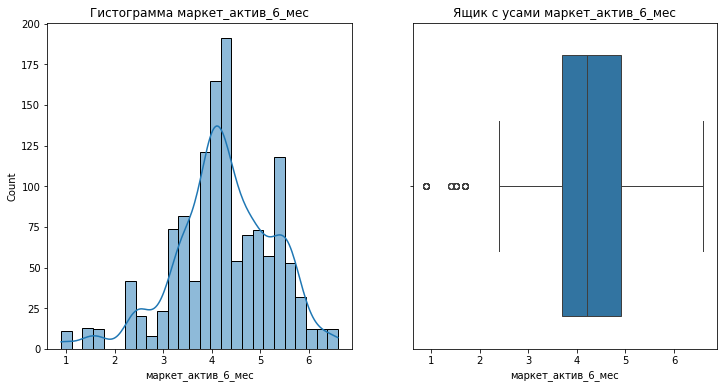

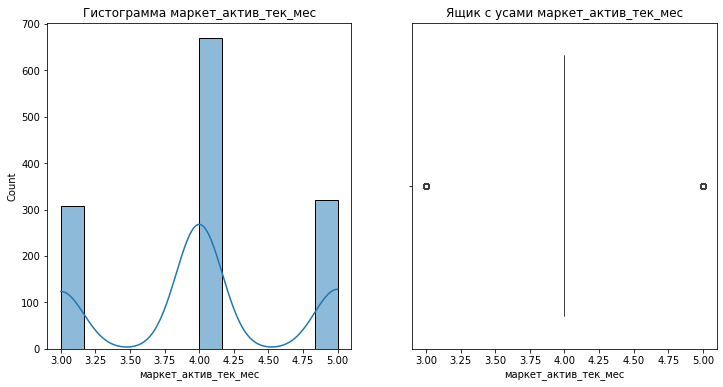

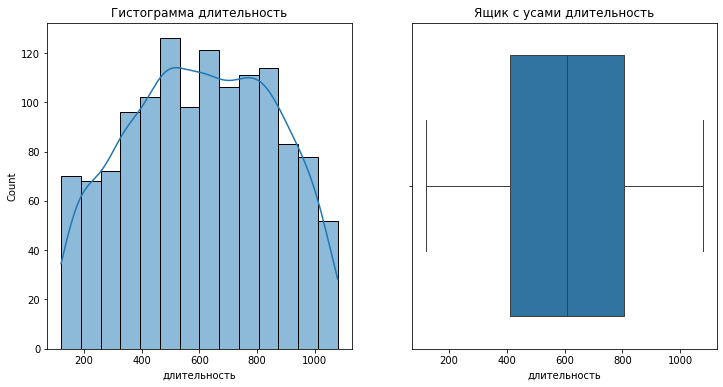

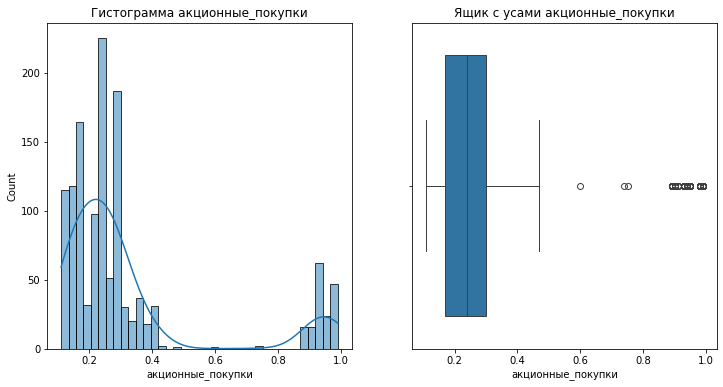

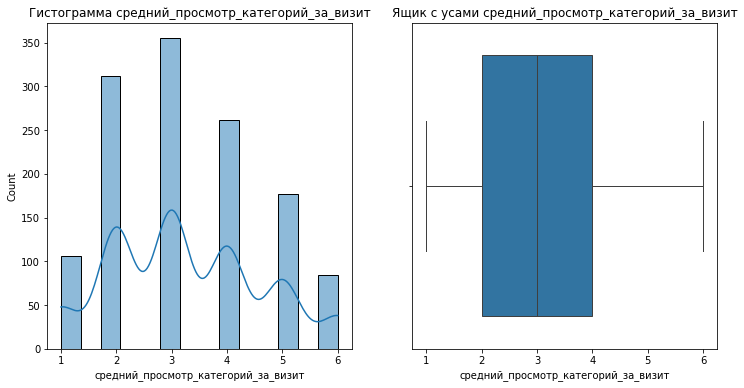

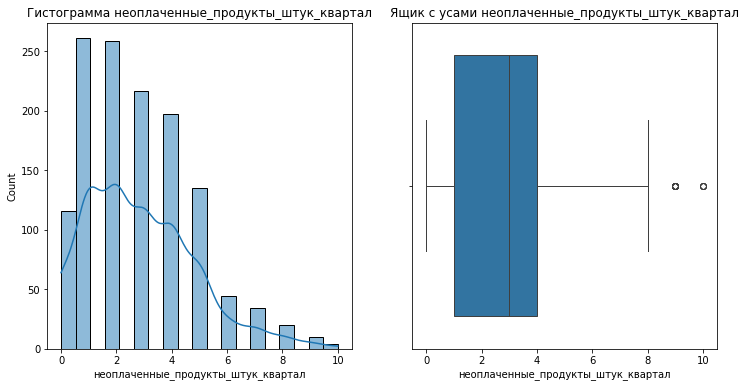

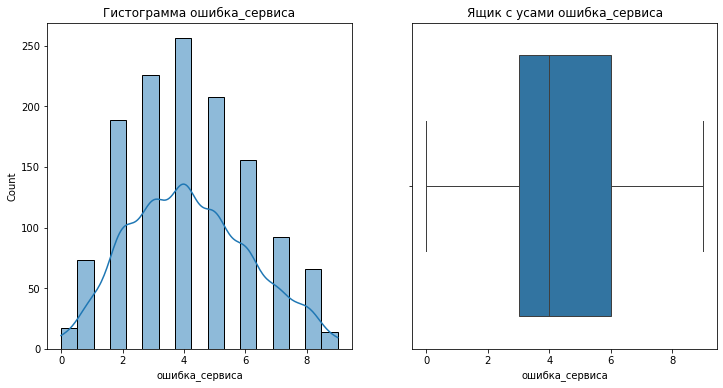

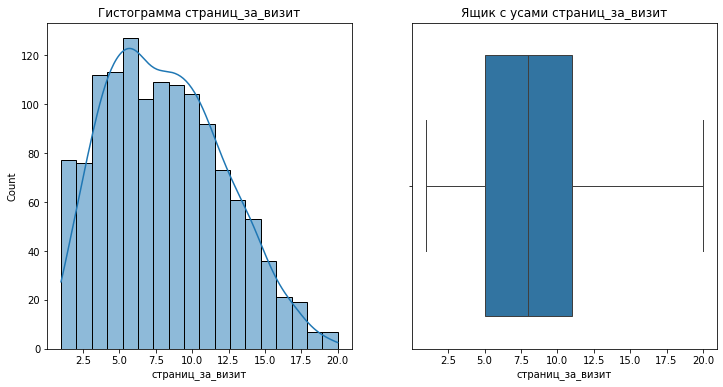

In [21]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(market_file_df[column], kde=True)
    plt.title(f'Гистограмма {column}')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=market_file_df[column])
    plt.title(f'Ящик с усами {column}')
    
    plt.show()

Вывод:

- замечен странный пик в районе 0.9 в столбце акционные_покупки. Не могу сказать, что это выброс, просто такое распределение данных

- у маркет_актив_тек_мес обнаружена странная картина.

- Выбросов как таковых не обнаружено

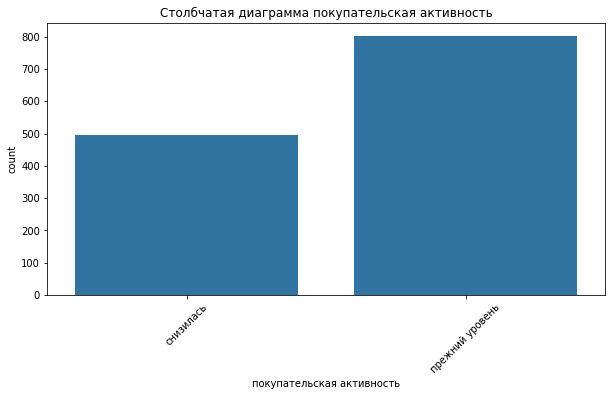

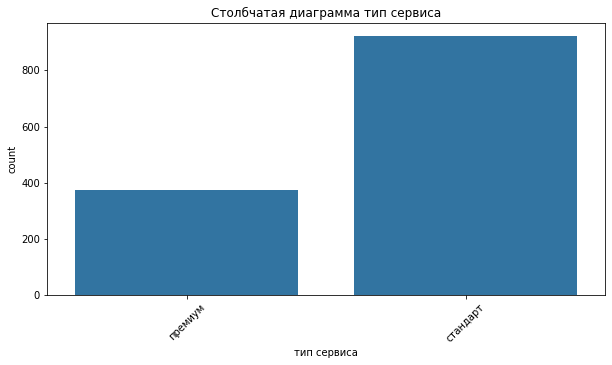

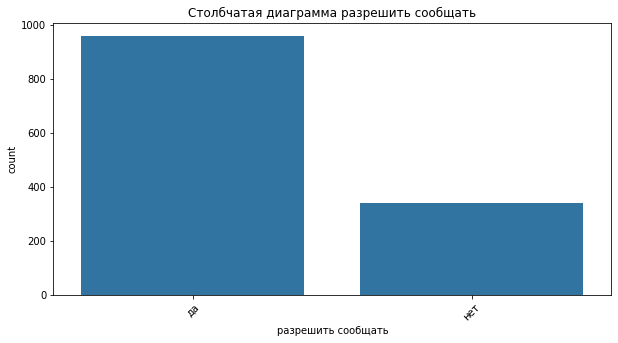

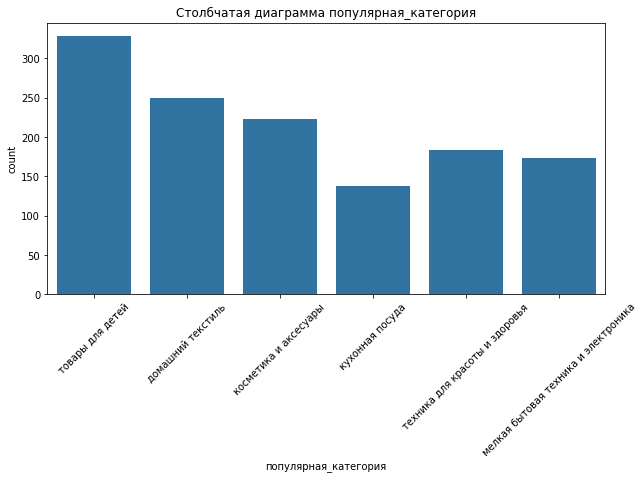

In [22]:
categorical_columns = ['покупательская активность', 'тип сервиса', 'разрешить сообщать', 'популярная_категория']

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    
    # Столбчатая диаграмма
    sns.countplot(data=market_file_df, x=column)
    plt.title(f'Столбчатая диаграмма {column}')
    plt.xticks(rotation=45)
    
    plt.show()

Вывод:

- целевой признак покупательская активность меет дисбаланс классов, учтем это в следующих шагах

- стандартных пользователей в более чем два раза больше чем премиум.

- клиенты в три раза чаще разрешают присылать дополнительные предложения о товаре

- популярный товар - товары для детей, за ним идет кухонная посуда

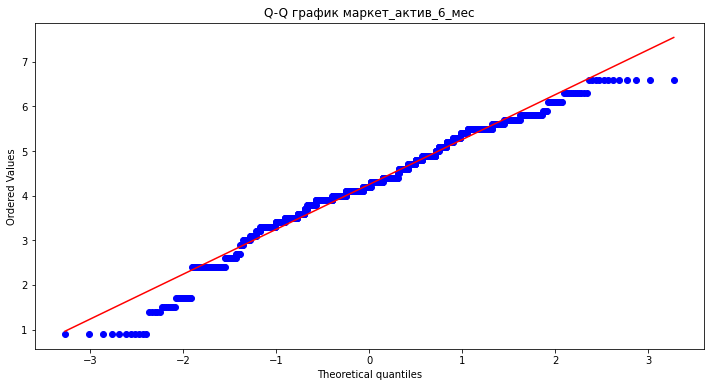

Тест Шапиро-Уилка для маркет_актив_6_мес: p-value = 3.334970645994806e-13


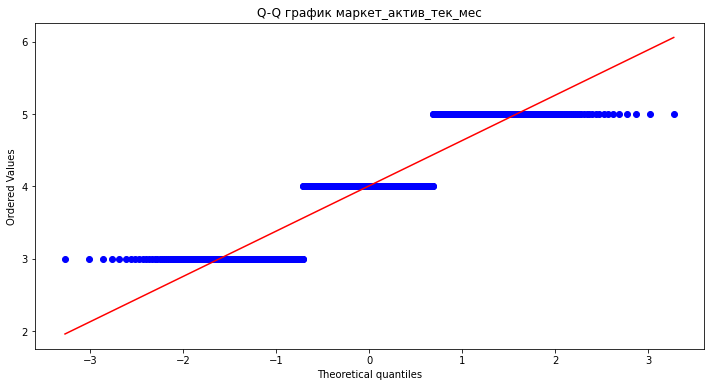

Тест Шапиро-Уилка для маркет_актив_тек_мес: p-value = 7.828221812583313e-37


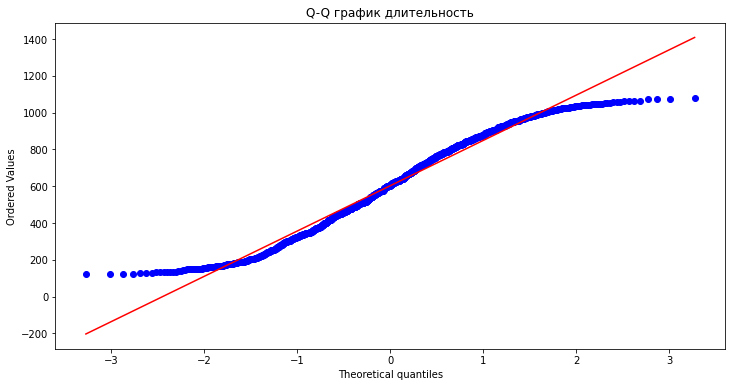

Тест Шапиро-Уилка для длительность: p-value = 6.022633377390308e-15


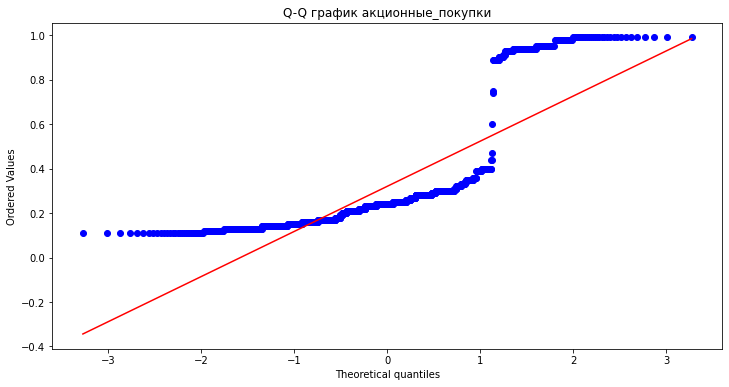

Тест Шапиро-Уилка для акционные_покупки: p-value = 4.203895392974451e-45


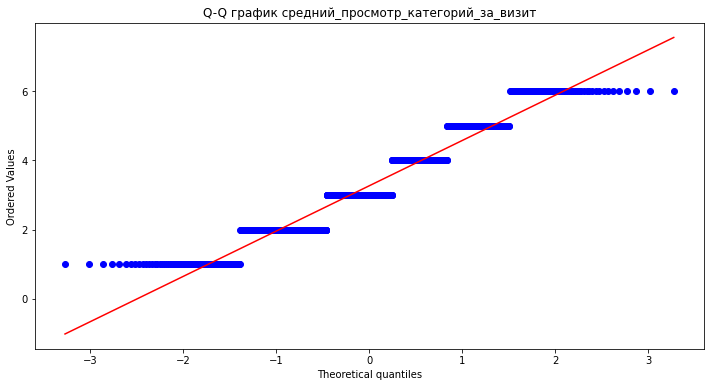

Тест Шапиро-Уилка для средний_просмотр_категорий_за_визит: p-value = 4.569419995507535e-24


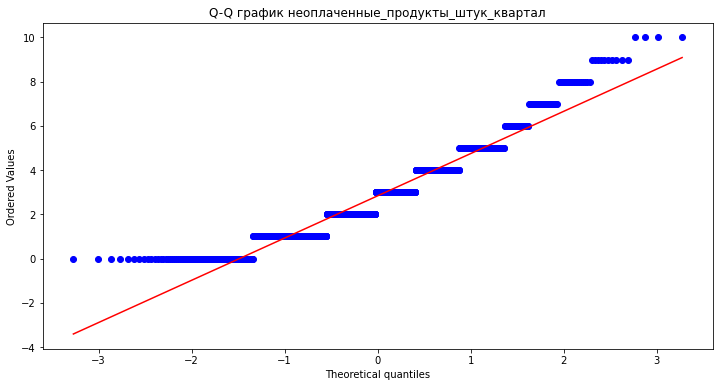

Тест Шапиро-Уилка для неоплаченные_продукты_штук_квартал: p-value = 1.1098016281037619e-23


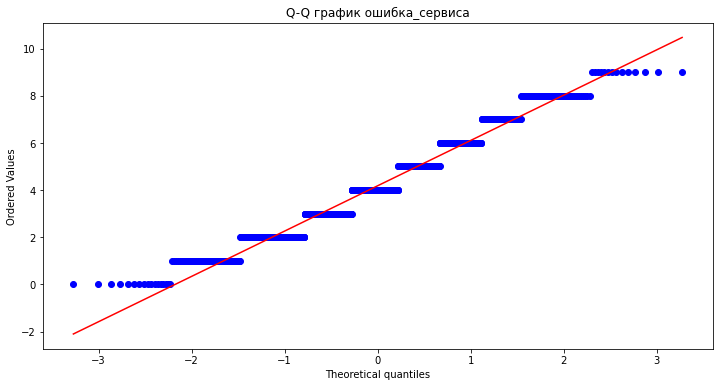

Тест Шапиро-Уилка для ошибка_сервиса: p-value = 6.413092907943201e-17


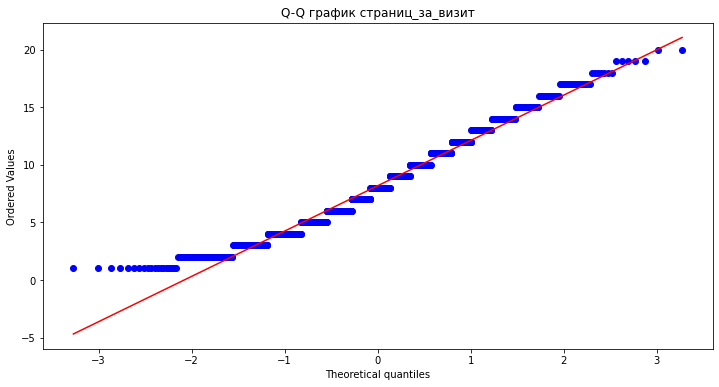

Тест Шапиро-Уилка для страниц_за_визит: p-value = 1.535947035519441e-14


In [23]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Q-Q график
    stats.probplot(market_file_df[column].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q график {column}')
    
    plt.show()
    
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(market_file_df[column].dropna())
    print(f'Тест Шапиро-Уилка для {column}: p-value = {p_value}')

Вывод: Результаты теста Шапиро-Уилка для всех переменных показывают крайне низкие значения p-value, все ниже порога значимости 0.05. Это означает, что для всех переменных гипотеза о нормальности распределения отвергается с высокой уверенностью.

In [24]:
# Статистический анализ количественных данных
market_money_df.describe()

,id,выручка
count,3891.000000,3891.000000
mean,215998.986893,5033.718890
std,374.482249,1768.471286
min,215349.000000,2758.700000
25%,215675.000000,4592.000000
50%,215999.000000,4959.000000
75%,216323.000000,5363.200000
max,216647.000000,106862.200000


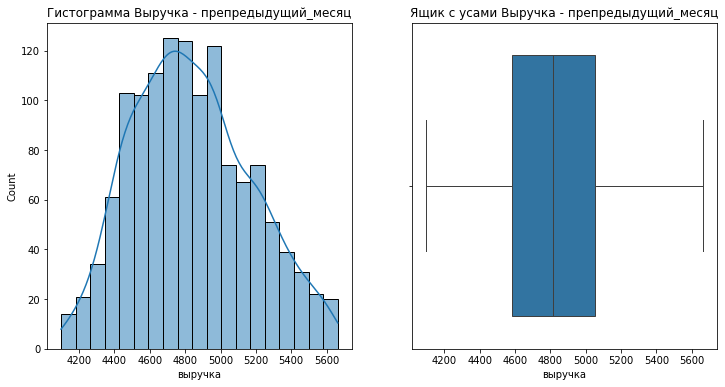

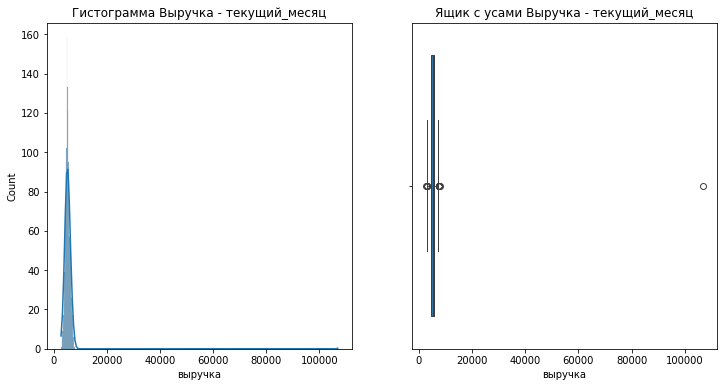

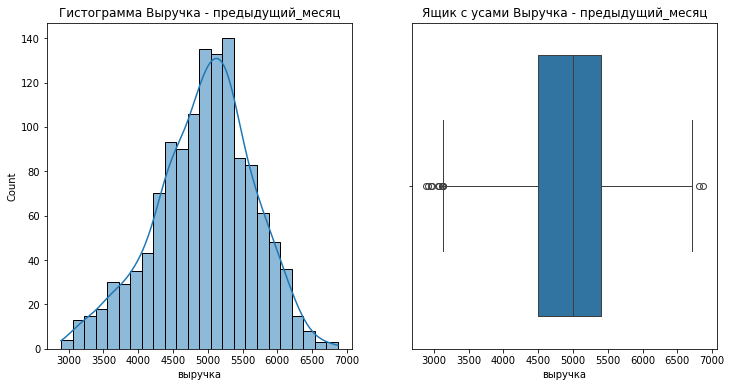

In [25]:
for period in market_money_df['период'].unique():
    plt.figure(figsize=(12, 6))
    subset = market_money_df[market_money_df['период'] == period]
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(subset['выручка'], kde=True)
    plt.title(f'Гистограмма Выручка - {period}')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=subset['выручка'])
    plt.title(f'Ящик с усами Выручка - {period}')
    
    plt.show()

Вывод: наблюдается выброс в столбце текущий_мес, удалим его

In [26]:
market_money_df = market_money_df[market_money_df['выручка'] < 20000]

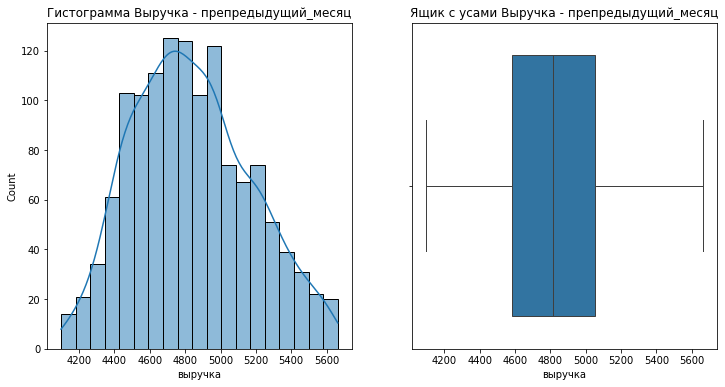

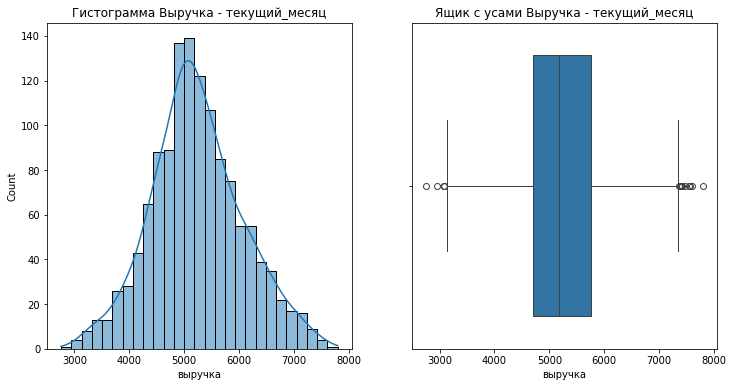

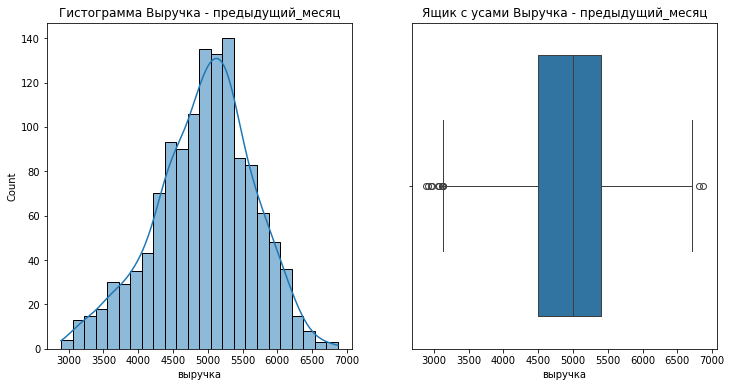

In [27]:
for period in market_money_df['период'].unique():
    plt.figure(figsize=(12, 6))
    subset = market_money_df[market_money_df['период'] == period]
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(subset['выручка'], kde=True)
    plt.title(f'Гистограмма Выручка - {period}')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=subset['выручка'])
    plt.title(f'Ящик с усами Выручка - {period}')
    
    plt.show()

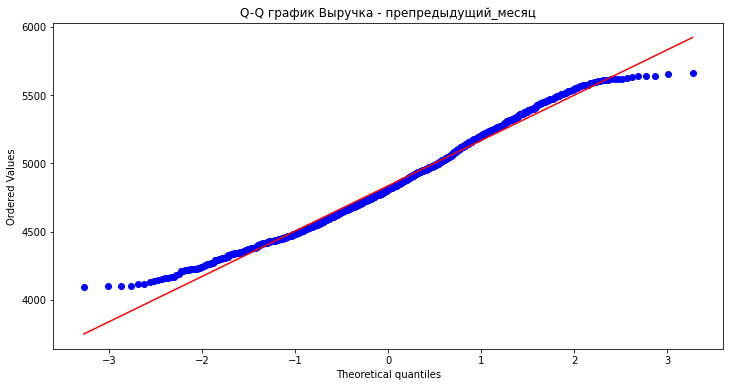

Тест Шапиро-Уилка для Выручка - препредыдущий_месяц: p-value = 1.2515357639131253e-09


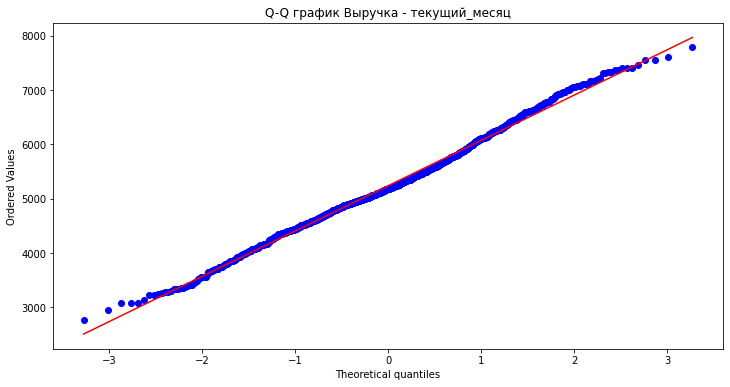

Тест Шапиро-Уилка для Выручка - текущий_месяц: p-value = 0.00015330837049987167


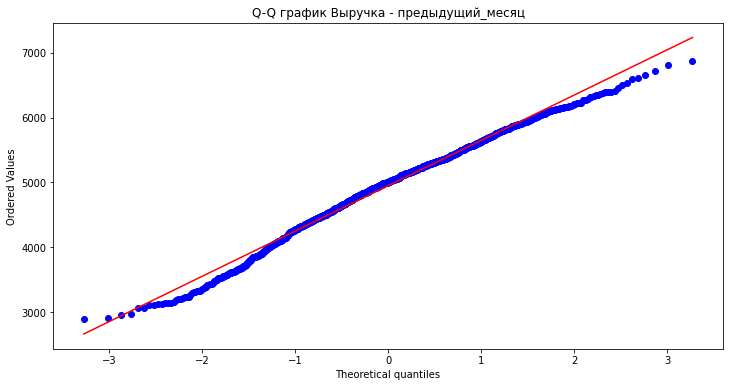

Тест Шапиро-Уилка для Выручка - предыдущий_месяц: p-value = 1.3117016806063475e-07


In [28]:
for period in market_money_df['период'].unique():
    plt.figure(figsize=(12, 6))
    subset = market_money_df[market_money_df['период'] == period]
    
    # Q-Q график
    stats.probplot(subset['выручка'].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q график Выручка - {period}')
    
    plt.show()
    
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(subset['выручка'].dropna())
    print(f'Тест Шапиро-Уилка для Выручка - {period}: p-value = {p_value}')

Вывод: Все значения p-value значительно меньше 0.05, что указывает на отклонение от нормального распределения для выручки в каждый из указанных периодов. Таким образом, данные по выручке не следуют нормальному распределению.

In [29]:
market_time_df.describe()

,id,минут
count,2594.000000,2594.000000
mean,215998.986893,13.340401
std,374.506318,4.081999
min,215349.000000,4.000000
25%,215675.000000,10.000000
50%,215999.000000,13.000000
75%,216323.000000,16.000000
max,216647.000000,23.000000


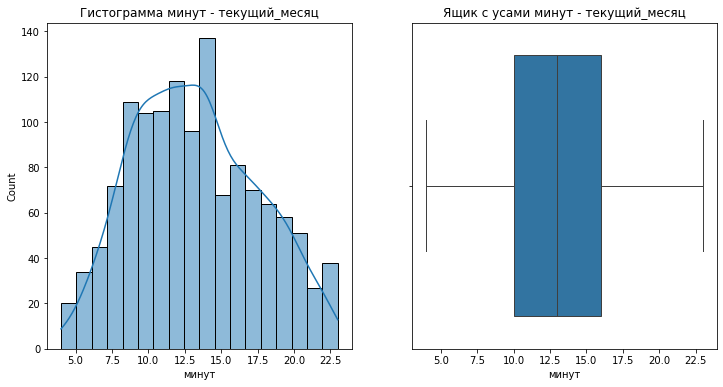

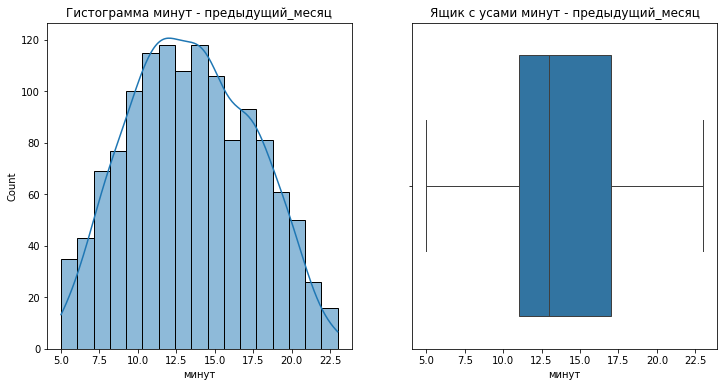

In [30]:
for period in market_time_df['период'].unique():
    plt.figure(figsize=(12, 6))
    subset = market_time_df[market_time_df['период'] == period]
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(subset['минут'], kde=True)
    plt.title(f'Гистограмма минут - {period}')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=subset['минут'])
    plt.title(f'Ящик с усами минут - {period}')
    
    plt.show()

Вывод: Выбросов не обнаружено

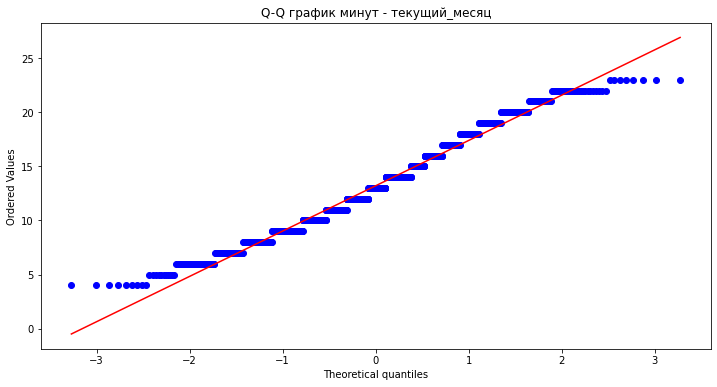

Тест Шапиро-Уилка для минут - текущий_месяц: p-value = 1.5859968503437183e-12


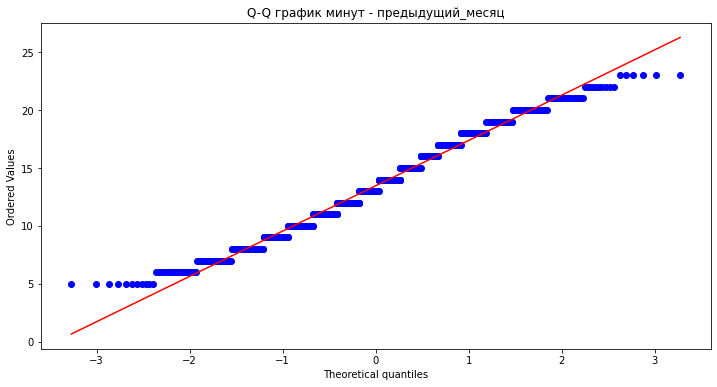

Тест Шапиро-Уилка для минут - предыдущий_месяц: p-value = 2.619819985949512e-11


In [31]:
for period in market_time_df['период'].unique():
    plt.figure(figsize=(12, 6))
    subset = market_time_df[market_time_df['период'] == period]
    
    # Q-Q график
    stats.probplot(subset['минут'].dropna(), dist="norm", plot=plt)
    plt.title(f'Q-Q график минут - {period}')
    
    plt.show()
    
    # Тест Шапиро-Уилка
    stat, p_value = stats.shapiro(subset['минут'].dropna())
    print(f'Тест Шапиро-Уилка для минут - {period}: p-value = {p_value}')

Вывод: значения значительно отклоняются от нормального

In [32]:
money_df.describe()

,id,прибыль
count,1297.000000,1297.000000
mean,215998.986893,3.997610
std,374.578554,1.010813
min,215349.000000,0.860000
25%,215675.000000,3.300000
50%,215999.000000,4.040000
75%,216323.000000,4.670000
max,216647.000000,7.430000


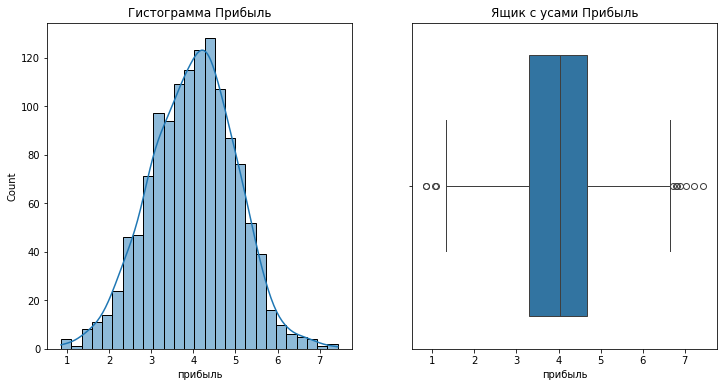

In [33]:
plt.figure(figsize=(12, 6))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(money_df['прибыль'], kde=True)
plt.title('Гистограмма Прибыль')

# Ящик с усами
plt.subplot(1, 2, 2)
sns.boxplot(x=money_df['прибыль'])
plt.title('Ящик с усами Прибыль')

plt.show()

Вывод: выбросов не обнаружено

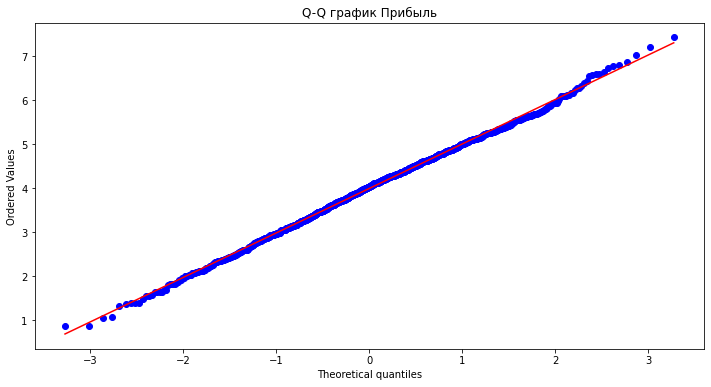

Тест Шапиро-Уилка для Прибыль: p-value = 0.35099291801452637


In [34]:
plt.figure(figsize=(12, 6))

# Q-Q график
stats.probplot(money_df['прибыль'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q график Прибыль')

plt.show()

# Тест Шапиро-Уилка
stat, p_value = stats.shapiro(money_df['прибыль'].dropna())
print(f'Тест Шапиро-Уилка для Прибыль: p-value = {p_value}')

P-value для теста Шапиро-Уилка равное 0.351 указывает на то, что нет оснований отвергать гипотезу о нормальности распределения данных. В данном случае распределение данных о прибыли не отклоняется от нормального, и можно считать, что оно нормально распределено.

Выводы:

Клиенты с активностью не менее трёх месяцев отобраны и таблицы обновлены.
Пропуски и дубликаты в таблицах отсутствуют

- Таблица market_file_df:

Наблюдается необычный пик в столбце акционные_покупки, но нет явных выбросов.
Распределение данных не соответствует нормальному
Выбросов не найдено.
Целевой признак имеет дисбаланс классов: стандартных пользователей в два раза больше, чем премиум.
Клиенты в три раза чаще разрешают получать дополнительные предложения о товаре.
Популярный товар — товары для детей, затем кухонная посуда.
Данные отклоняются от нормального распределения (p-value < 0.05).

- Таблица market_money_df:

Удалён выброс в столбце текущий_мес.
Выручка не следует нормальному распределению (p-value < 0.05).

- Таблица market_time_df:

Выбросов не обнаружено.
Значения данных значительно отклоняются от нормального распределения.

- Таблица money_df:

Выбросов не обнаружено.
Распределение данных о прибыли нормально (p-value = 0.351).

## Объединение таблиц

In [35]:
# Преобразование таблицы выручки: создание отдельных столбцов для каждого периода
market_money_pivot = market_money_df.pivot(index='id', columns='период', values='выручка').reset_index()
market_money_pivot.columns.name = None  # Удаление имени столбца
market_money_pivot = market_money_pivot.rename(columns={'препредыдущий_месяц': 'выручка_препредыдущий_месяц',
                                                       'предыдущий_месяц': 'выручка_предыдущий_месяц',
                                                       'текущий_месяц': 'выручка_текущий_месяц'})

# Преобразование таблицы времени на сайте: создание отдельных столбцов для каждого периода
market_time_pivot = market_time_df.pivot(index='id', columns='период', values='минут').reset_index()
market_time_pivot.columns.name = None 
market_time_pivot = market_time_pivot.rename(columns={'предыдущий_месяц': 'время_предыдущий_месяц',
                                                      'текущий_месяц': 'время_текущий_месяц'})

merged_df = pd.merge(market_file_df, market_money_pivot, on='id', how='left')
merged_df = pd.merge(merged_df, market_time_pivot, on='id', how='left')

merged_df.head()

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


In [36]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская активность            1297 non-null   object 
 2   тип сервиса                          1297 non-null   object 
 3   разрешить сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

In [37]:
merged_df['выручка_текущий_месяц'].fillna(merged_df['выручка_текущий_месяц'].median(), inplace=True)

In [38]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1297 non-null   int64  
 1   покупательская активность            1297 non-null   object 
 2   тип сервиса                          1297 non-null   object 
 3   разрешить сообщать                   1297 non-null   object 
 4   маркет_актив_6_мес                   1297 non-null   float64
 5   маркет_актив_тек_мес                 1297 non-null   int64  
 6   длительность                         1297 non-null   int64  
 7   акционные_покупки                    1297 non-null   float64
 8   популярная_категория                 1297 non-null   object 
 9   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 11  ошибка_сервиса                

Вывод: были объединены таблицы market_file.csv , market_money.csv , market_time.csv. В итоговой таблице сделали отдельный столбец для каждого периода.

## Корреляционный анализ

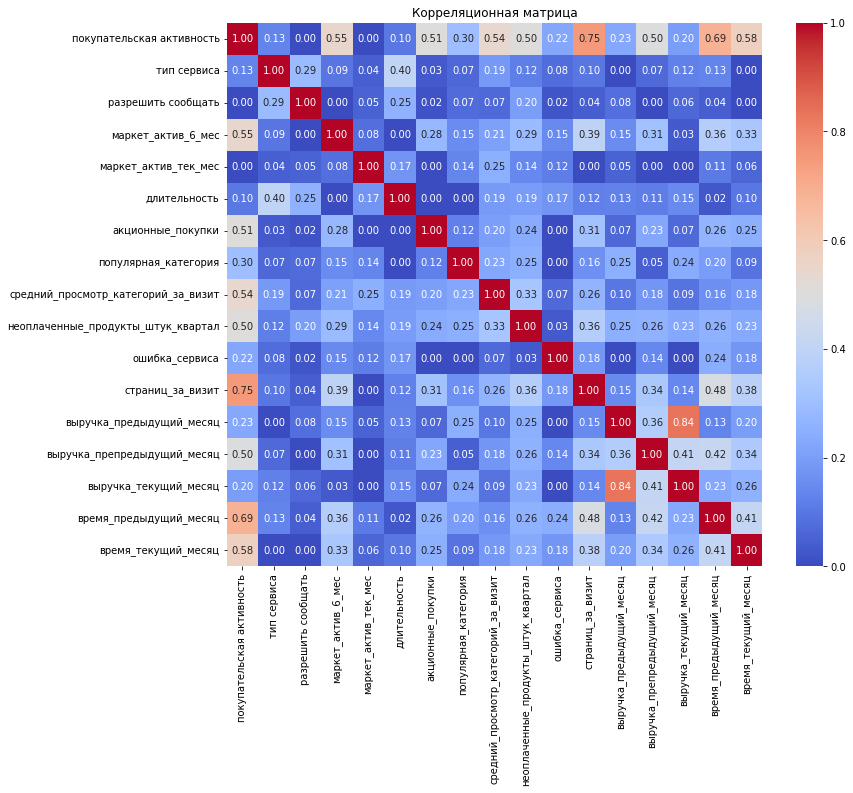

In [39]:
merged_df_phik = merged_df.drop(['id'], axis=1)
merged_df_with_id = merged_df
interval_cols = merged_df_phik.select_dtypes(include=['float64', 'int64']).columns

phik_matrix = merged_df_phik.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Вывод: Корреляция меньше 0.9, а это значит, что мультиколлинеарности нет. 

## Использование пайплайнов

In [40]:
merged_df = merged_df_phik

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297 entries, 0 to 1296
Data columns (total 17 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   покупательская активность            1297 non-null   object 
 1   тип сервиса                          1297 non-null   object 
 2   разрешить сообщать                   1297 non-null   object 
 3   маркет_актив_6_мес                   1297 non-null   float64
 4   маркет_актив_тек_мес                 1297 non-null   int64  
 5   длительность                         1297 non-null   int64  
 6   акционные_покупки                    1297 non-null   float64
 7   популярная_категория                 1297 non-null   object 
 8   средний_просмотр_категорий_за_визит  1297 non-null   int64  
 9   неоплаченные_продукты_штук_квартал   1297 non-null   int64  
 10  ошибка_сервиса                       1297 non-null   int64  
 11  страниц_за_визит              

In [41]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

ohe_columns = ['популярная_категория']

ord_columns = [
    'тип сервиса', 'разрешить сообщать'
]

num_columns = merged_df.select_dtypes(include=['float64', 'int64']).columns

In [42]:
num_pipe = Pipeline(
    [
    ('simpleImputer_num', SimpleImputer(strategy='median')),
    ('scaler_standard', StandardScaler()),  
    ('scaler_minmax', MinMaxScaler())   
    ]
)

ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# SimpleImputer + ORD + SimpleImputer
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'], 
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('num', num_pipe, num_columns),
        ('ord', ord_pipe, ord_columns),
        ('ohe', ohe_pipe, ohe_columns)
    ],
    remainder='passthrough'
)

In [43]:
merged_df.select_dtypes(include=['object'])

,покупательская активность,тип сервиса,разрешить сообщать,популярная_категория
0,снизилась,премиум,да,товары для детей
1,снизилась,стандарт,нет,домашний текстиль
2,снизилась,стандарт,да,товары для детей
3,снизилась,стандарт,нет,товары для детей
4,снизилась,стандарт,да,домашний текстиль
...,...,...,...,...
1292,прежний уровень,стандарт,да,техника для красоты и здоровья
1293,прежний уровень,стандарт,нет,домашний текстиль
1294,прежний уровень,стандарт,да,домашний текстиль
1295,прежний уровень,стандарт,да,техника для красоты и здоровья


In [44]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Пайплайн для моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 7),
        'models__max_features': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(2, 4),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(['покупательская активность'], axis=1), 
    merged_df['покупательская активность'], 
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = merged_df['покупательская активность']
    )

target_encoder = LabelEncoder()
target_encoder.fit(y_train)

y_train = target_encoder.transform(y_train)
y_test = target_encoder.transform(y_test)

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_grid, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('simpleImputer_num',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler_standard',
                                                                                                StandardScaler()),
                                                                                               ('scaler_minmax',
                                                                                                MinMaxScaler())]),
                                                                               Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупк...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(2, 4),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [46]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search.best_score_)
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика roc_auc для лучшей модели:
 0.896780314198496

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', 'passthrough',
                                                  Index(['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность',
       'акционные_покупки', 'средний_просмотр_категорий_за_визит',
       'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса',
       'страниц_за_визит', 'выручка_предыдущий_месяц',
       'выручка_препреды...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['тип сервиса',
                                                   'разрешить сообщать']),
                                                 ('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                   

Лучшей моделей оказалась LogisticRegression, со следующими настройками: C=3, penalty='l1', random_state=42, solver='liblinear'

Выбрали метрику roc_auc, так как целевой признак несбалансирован. Она лучше всего для задач с несбалансированными классами, так как она учитывает и истинные положительные, и ложные положительные с различными порогами, предоставляя более полное представление о производительности модели.

In [47]:
result = pd.DataFrame(randomized_search.cv_results_)

pd.set_option('display.max_colwidth', None)

result[
    ['rank_test_score', 'mean_test_score','params']
].sort_values('rank_test_score')

,rank_test_score,mean_test_score,params
8,1,0.896780,"{'preprocessor__num': 'passthrough', 'models__C': 3, 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}"
5,2,0.828973,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 4, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
1,3,0.816562,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 5, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
9,3,0.816562,"{'preprocessor__num': 'passthrough', 'models__max_features': 5, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"
7,5,0.812605,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 5, 'models': DecisionTreeClassifier(random_state=42)}"
4,6,0.750456,"{'preprocessor__num': 'passthrough', 'models__max_features': 2, 'models__max_depth': 6, 'models': DecisionTreeClassifier(random_state=42)}"
3,7,0.729295,"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 4, 'models': KNeighborsClassifier()}"
0,8,0.722271,"{'preprocessor__num': 'passthrough', 'models__n_neighbors': 2, 'models': KNeighborsClassifier()}"
6,9,0.718960,"{'preprocessor__num': StandardScaler(), 'models__max_features': 2, 'models__max_depth': 4, 'models': DecisionTreeClassifier(random_state=42)}"
2,10,0.710746,"{'preprocessor__num': MinMaxScaler(), 'models__max_features': 3, 'models__max_depth': 2, 'models': DecisionTreeClassifier(random_state=42)}"


## Анализ важности признаков

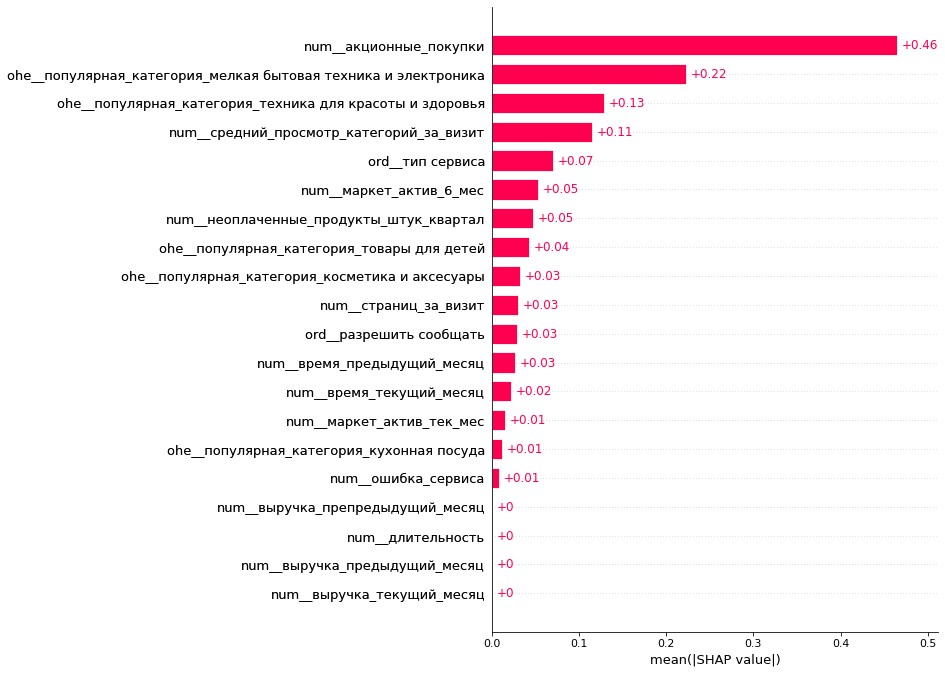

In [48]:
X_train_transformed = pipe_final.named_steps['preprocessor'].fit_transform(X_train)

explainer = shap.LinearExplainer(randomized_search.best_estimator_.named_steps['models'], X_train_transformed)

X_test_transformed = pipe_final.named_steps['preprocessor'].transform(X_test)

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()

X_test_transformed = pd.DataFrame(X_test_transformed, columns=feature_names)
 
shap_values = explainer(X_test_transformed)
 
shap.plots.bar(shap_values, max_display=30)

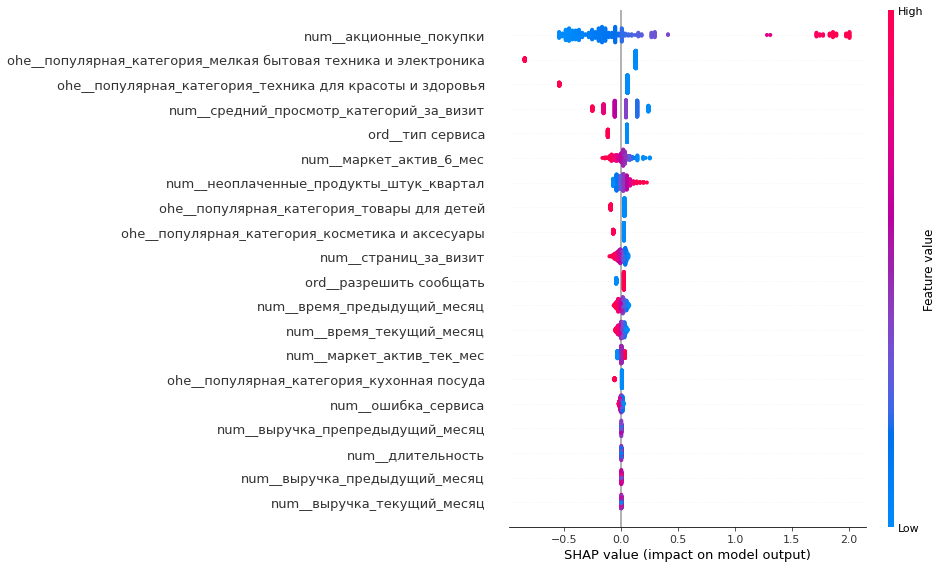

In [49]:
shap.plots.beeswarm(shap_values, max_display=20)

Вывод:

Были построены графики SHAP, на которых показана важность признаков для модели.

Мало значимые признаки: Признаки с низкими SHAP значениями, такие как:

- num_выручка_текущий_месяц
- num_длительность
- num_выручка_предыдущий_месяц

оказывают минимальное влияние на модель. Эти признаки могут быть исключены или учтены меньше в дальнейших итерациях моделирования.

Наиболее значимые признаки: Наибольший вклад оказывают признаки 

- num_акционные_покупки
- ohe_популярная_категория_мелкая бытовая техника и электроника
- ohe_популярная_категория_техника для красоты и здоровья

Эти признаки влияют на результат модели сильнее всего, что говорит о том, что они играют важную роль в предсказании целевого признака.

Использование наблюдений при моделировании и принятии бизнес-решений:

- Оптимизация модели: Признаки с минимальным влиянием, такие как num_выручка_текущий_месяц, могут быть исключены для уменьшения сложности модели и повышения её интерпретируемости. Это улучшит производительность и упростит объяснение результатов.

- Фокус на важных признаках: Внимание следует уделить наиболее значимым признакам, таким как num_акционные_покупки, ohe_популярная_категория_мелкая бытовая техника и электроника, и ohe_популярная_категория_техника для красоты и здоровья. Эти признаки стоит детально анализировать и использовать для управления бизнес-решениями.

- Принятие решений: Понимание ключевых признаков позволяет бизнесу концентрироваться на тех факторах, которые влияют на целевую переменную. Например, если важные признаки связаны с поведением клиентов, можно улучшить маркетинговые стратегии, основываясь на этих данных.

## Сегментация покупателей

1. Группа клиентов с максимальной долей покупок по акции и высокой вероятностью снижения покупательской активности

Выберем в качестве сегмента пользователей, которые часто покупают по скидке. Очевидно, что они имеют наибольшее снижение покупательской активности.

In [50]:
y_test_proba = randomized_search.predict_proba(X_test)[:,1]
y_train_proba = randomized_search.predict_proba(X_train)[:,1]

In [51]:
X_test_full = X_test.copy()
X_test_full['вероятность_снижения_активности'] = y_test_proba

X_train_full = X_train.copy()
X_train_full['вероятность_снижения_активности'] = y_train_proba

df_full = pd.concat([X_train_full, X_test_full])

merged_df_with_id = pd.merge(merged_df_with_id, df_full, how='inner')

merged_df_with_id = merged_df_with_id.merge(money_df, how='left')

merged_df_with_id

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,вероятность_снижения_активности,прибыль
0,215349,снизилась,премиум,да,4.4,4,819,0.75,товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,0.906295,4.16
1,215350,снизилась,стандарт,нет,4.9,3,539,0.14,домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,0.387407,3.13
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.815525,4.87
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.966579,4.21
4,215353,снизилась,стандарт,да,3.3,4,762,0.26,домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10,0.607176,3.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,216643,прежний уровень,стандарт,да,6.6,3,318,0.24,техника для красоты и здоровья,5,3,3,11,3664.0,4704.0,4741.7,14,7,0.034979,4.44
1315,216644,прежний уровень,стандарт,нет,5.1,4,454,0.21,домашний текстиль,6,2,3,9,4729.0,5299.0,5353.0,12,11,0.056832,6.11
1316,216645,прежний уровень,стандарт,да,4.1,3,586,0.20,домашний текстиль,3,2,5,7,5160.0,5334.0,5139.2,12,18,0.243334,3.29
1317,216646,прежний уровень,стандарт,да,6.3,5,645,0.12,техника для красоты и здоровья,3,3,5,7,4923.0,4725.0,5224.6,18,7,0.153091,4.03


Отфильтруем пользователей, которые имеют большую вероятность снижения активности, и у которых большая доля покупок по акции.

In [52]:
segmented_df = merged_df_with_id.query('акционные_покупки >= 0.8 and вероятность_снижения_активности >= 0.8')
segmented_df

,id,покупательская активность,тип сервиса,разрешить сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц,вероятность_снижения_активности,прибыль
2,215351,снизилась,стандарт,да,3.2,5,896,0.99,товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,0.815525,4.87
3,215352,снизилась,стандарт,нет,5.1,3,1064,0.94,товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,0.966579,4.21
13,215364,снизилась,премиум,да,4.3,4,708,0.98,домашний текстиль,3,3,3,3,5795.5,4942.0,5484.8,11,9,0.969946,2.67
14,215365,снизилась,стандарт,да,3.9,4,167,0.95,техника для красоты и здоровья,6,4,2,5,4577.0,4190.0,4799.3,6,10,0.896171,3.65
22,215373,снизилась,премиум,нет,3.8,3,811,0.90,товары для детей,2,5,5,3,4632.0,4293.0,5161.1,10,8,0.989120,3.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604,215933,снизилась,стандарт,да,4.6,4,316,0.95,косметика и аксесуары,2,5,6,13,6102.0,5532.0,6726.0,11,10,0.833766,4.05
611,215940,снизилась,премиум,да,5.7,5,903,0.99,косметика и аксесуары,2,8,6,12,4525.0,4691.0,4799.3,13,18,0.854186,2.09
1042,216371,прежний уровень,стандарт,нет,3.3,3,414,0.94,домашний текстиль,2,1,5,9,5362.5,5124.0,5699.2,14,10,0.816593,5.35
1235,216564,прежний уровень,стандарт,да,5.6,4,342,0.94,кухонная посуда,2,7,5,8,4930.0,5269.0,4766.2,14,19,0.811532,5.58


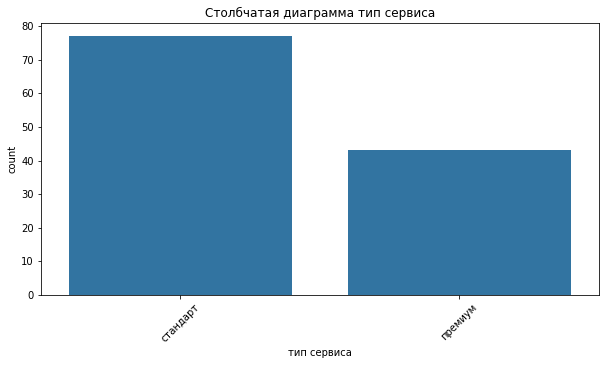

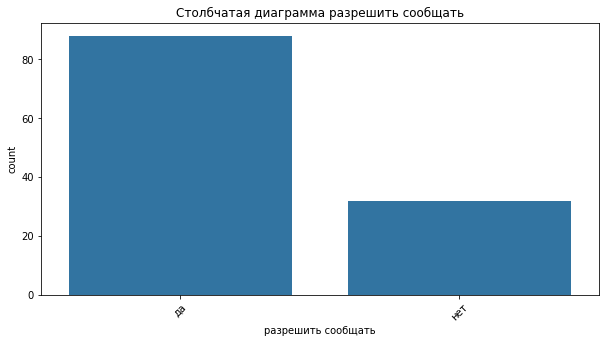

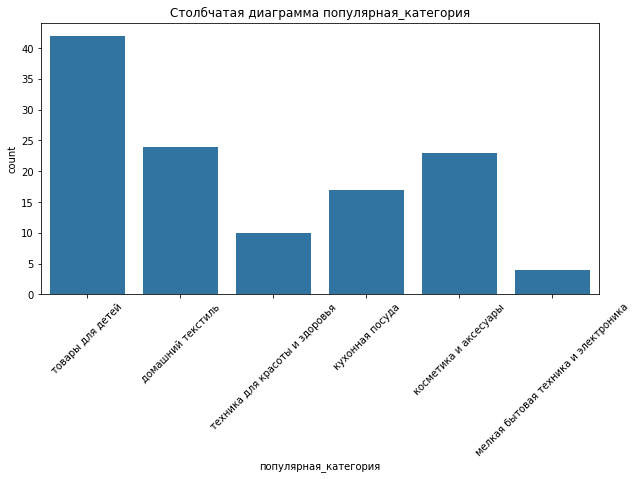

In [53]:
categorical_columns = ['тип сервиса', 'разрешить сообщать', 'популярная_категория']

for column in categorical_columns:
    plt.figure(figsize=(10, 5))
    
    # Столбчатая диаграмма
    sns.countplot(data=segmented_df, x=column)
    plt.title(f'Столбчатая диаграмма {column}')
    plt.xticks(rotation=45)
    
    plt.show()

Выводы:

- 2/3 пользователей выбранного сегмента имеют стандартный тип сервиса


- 3/4 пользователей выбранного сегмента позволяют присылать себе дополнительные предложения о товаре


- Популярными категориями выбранного сегмента являются: товары для детей, домашний текстиль, косметика и аксессуары.

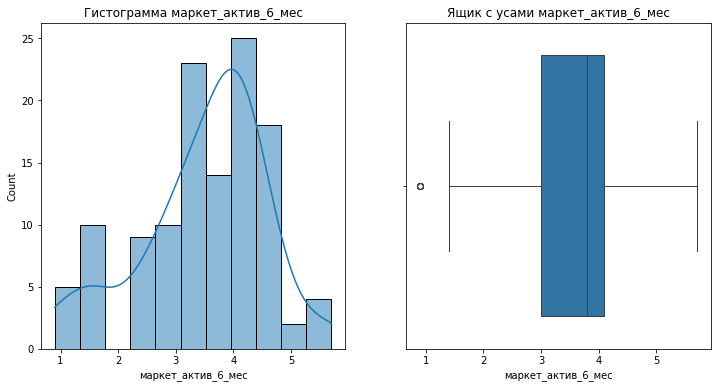

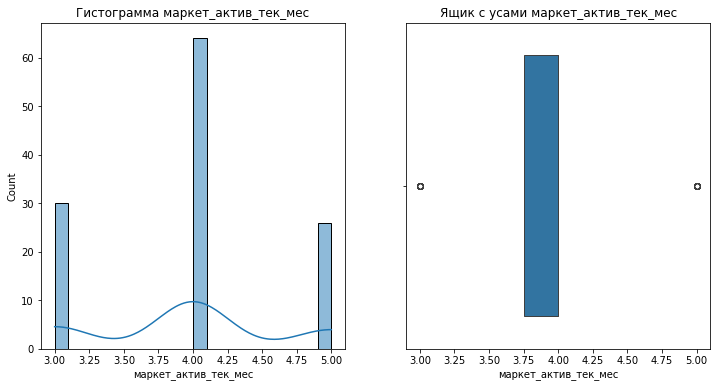

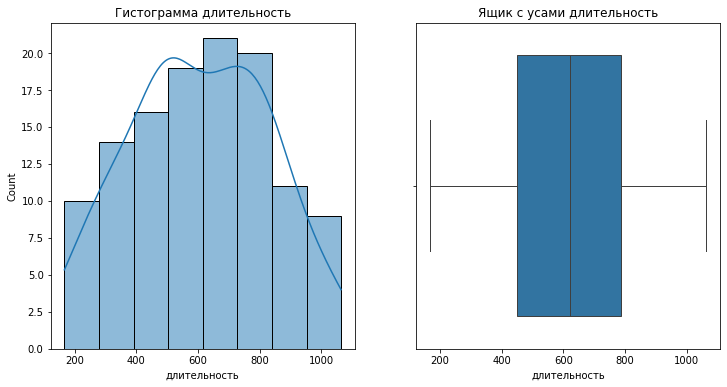

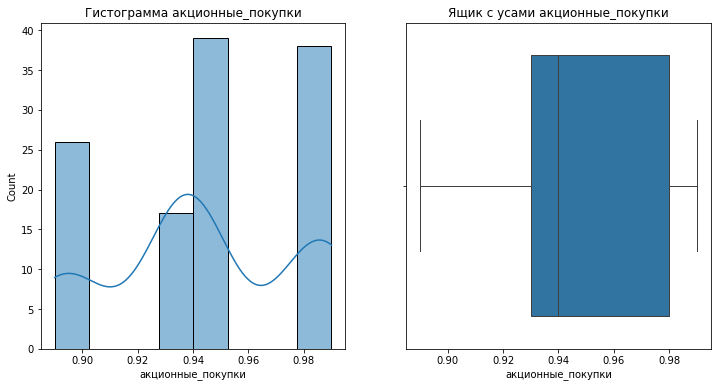

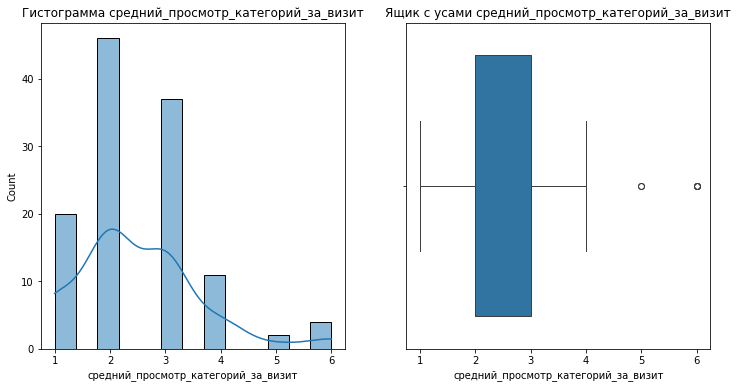

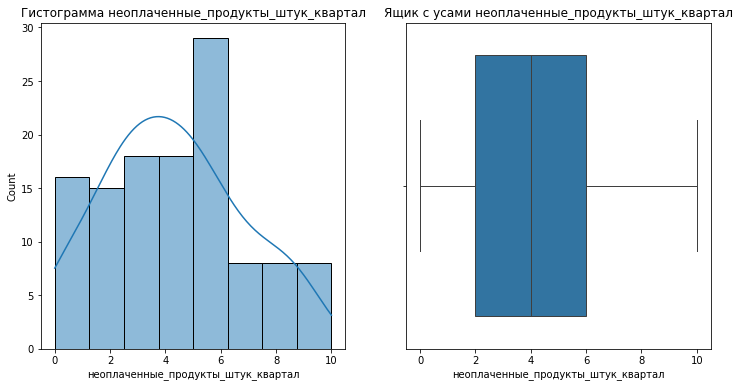

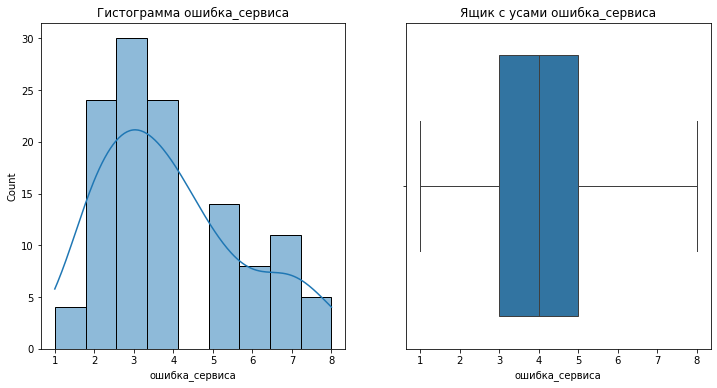

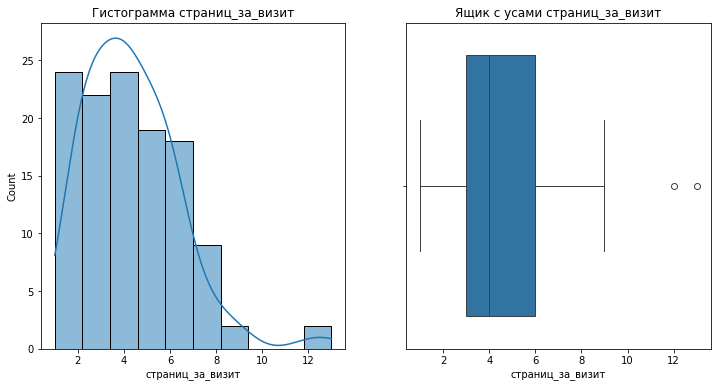

In [54]:
for column in quantitative_columns:
    plt.figure(figsize=(12, 6))
    
    # Гистограмма
    plt.subplot(1, 2, 1)
    sns.histplot(segmented_df[column], kde=True)
    plt.title(f'Гистограмма {column}')
    
    # Ящик с усами
    plt.subplot(1, 2, 2)
    sns.boxplot(x=segmented_df[column])
    plt.title(f'Ящик с усами {column}')
    
    plt.show()

Выводы:

- В среднем на клиентов выбранного сегмента приходилось от 3 до 4 единиц, которые показывают какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.


- В среднем на клиентов выбранного сегмента приходилось от 3.75 до 4 маркетинговых коммуникаций в текущем месяце.


- Возраст аккаунтов клиентов выбранного сегмента составил от 420 до 800 дней (среднее 610 дней).


- В среднем клиенты выбранного сегмента посмотрели от 2 до 3 категорий за визит в течение последнего месяца.


- В среднем клиенты выбранного сегмента имеют от 2 до 6 неоплаченных товаров в корзине за последние 3 месяца.


- В среднем клиентов коснулось от 3 до 5 сбоев во время посещения сайта.


- Клиенты в среднем смотрели по 4 страницы за один визит на сайт за последние 3 месяца.

Предложения по работе с сегментом:

Для увеличения покупательской активности в выбранном сегменте следует акцентировать внимание на стандартном типе сервиса, так как 2/3 пользователей предпочитают его, и активно использовать возможность отправки дополнительных предложений, учитывая, что 3/4 клиентов открыты к этому. Рекомендуется ориентироваться на популярные категории товаров — детские товары, домашний текстиль, косметику и аксессуары. Также стоит оптимизировать маркетинговые коммуникации, учитывая, что в среднем на одного клиента приходилось 3.75–4 контакта в месяц, и повысить качество обслуживания, чтобы минимизировать количество сбоев на сайте (3–5 за визит).

## Общий вывод

**Описание задачи:**

Задача — создать модель, которая предскажет вероятность снижения покупательской активности в следующие три месяца. Для этого собраны данные по четырём группам признаков: коммуникация с клиентом, продуктовое и покупательское поведение, а также поведение на сайте. Модель будет использоваться для сегментации клиентов и разработки персонализированных предложений, чтобы повысить их активность.

**Описание исходных данных и проведённой предобработки:**

market_file.csv: Содержит данные о покупательской активности, коммуникациях, акциях, и поведении покупателей на сайте. Основные поля: id покупателя, активность, тип сервиса, маркетинговые коммуникации, длительность регистрации, акции, популярные категории, неоплаченные продукты, ошибки сервиса и страницы за визит.

market_money.csv: Отображает выручку, полученную от покупателей за разные периоды (например, текущий и предыдущий месяц). Основные поля: id покупателя, период, выручка.

market_time.csv: Содержит информацию о времени, проведённом покупателем на сайте в минутах за разные периоды. Основные поля: id покупателя, период, минуты.

money.csv: Данные о среднемесячной прибыли от каждого покупателя за последние 3 месяца. Основные поля: id покупателя, прибыль.

*Предобработка*

Все названия столбцов приведены к нижнему регистру для единообразия. Значения строк в столбцах типа object также приведены к нижнему регистру.

В столбце Прибыль в таблице money.csv удалены разделители (например, запятые), и значения преобразованы в числовой формат.

В столбце Тип сервиса таблицы market_file_df исправлена опечатка 'стандартт' на 'стандарт'.

В столбце Период таблицы market_time_df исправлена опечатка 'предыдцщий_месяц' на 'предыдущий_месяц'.

**Поиск лучшей модели:**

Для поиска лучшей модели был создан пайплайн с несколькими уровнями предобработки и различными классификаторами. Пайплайн включает:
- Предобработка числовых данных с помощью StandardScaler и MinMaxScaler.
- Предобработка категориальных данных с использованием OneHotEncoder и OrdinalEncoder.
- Комбинированный предобработчик в ColumnTransformer, обрабатывающий числовые, категориальные и прочие данные.
- Также был настроен поиск гиперпараметров для моделей DecisionTreeClassifier, KNeighborsClassifier, LogisticRegression и SVC, с различными настройками предобработки и параметрами моделей.

**Лучшая модель:**

LogisticRegression, со следующими настройками: C=3, penalty='l1', random_state=42, solver='liblinear'
Лучшая модель, выбранная на основе настроек и точности, это LogisticRegression, со следующими настройками: C=3, penalty='l1', random_state=42, solver='liblinear'. Точность этой модели составила 0.897.

**Дополнительные предложения по работе с акционным сегментом:**

Для увеличения покупательской активности в выбранном сегменте следует акцентировать внимание на стандартном типе сервиса, так как 2/3 пользователей предпочитают его, и активно использовать возможность отправки дополнительных предложений, учитывая, что 3/4 клиентов открыты к этому. Рекомендуется ориентироваться на популярные категории товаров — детские товары, домашний текстиль, косметику и аксессуары. Также стоит оптимизировать маркетинговые коммуникации, учитывая, что в среднем на одного клиента приходилось 3.75–4 контакта в месяц, и повысить качество обслуживания, чтобы минимизировать количество сбоев на сайте (3–5 за визит).